In [13]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.quantum_info import Statevector
import numpy as np

# Define the target state |ψ_f⟩ as |+⟩ for this example
psi_f = Statevector([0.7071, 0.7071])  # Example target state |+⟩ (normalized)

# Oracle using interference-based detection
def interference_based_oracle(qc, candidate, ancillary):
    """Oracle that marks the state if it matches |ψ_f> using interference."""
    
    # Step 1: Put ancillary qubit into superposition
    qc.h(ancillary)
    
    # Step 2: Apply a controlled-U operation to detect overlap with |ψ_f⟩
    # Assume U is a Hadamard gate since |ψ_f⟩ = |+⟩ in this example
    qc.ch(candidate, ancillary)  # Controlled-Hadamard on the ancillary
    
    # Step 3: Apply phase flip based on interference pattern
    qc.cz(candidate, ancillary)
    
    # Step 4: Return ancillary to the computational basis
    qc.h(ancillary)

# Main circuit with multiple Grover iterations and interference-based oracle
def recover_initial_state_with_interference_oracle():    
    qc = QuantumCircuit(2)
    candidate, ancillary = 0, 1

    # Prepare the candidate initial state |ψ_0⟩
    qc.ry(np.pi / 4, candidate)

    qc.remove_final_measurements()

    # Apply Hamiltonian evolution to simulate |ψ_0⟩ -> |ψ_f⟩
    hamiltonian_evolution(qc, candidate, total_time=1.0, steps=50)

    # Apply multiple Grover iterations with the interference-based oracle
    num_iterations = 4
    for _ in range(num_iterations):
        interference_based_oracle(qc, candidate, ancillary)
        diffusion_operator(qc, candidate)

    # Simulate and retrieve the final statevector
    # simulator = BasicSimulator()
    # compiled_circuit = transpile(qc, simulator)
    # job = simulator.run(compiled_circuit, shots=1)
    # result = job.result()
    # final_state = Statevector(result.get_statevector())
    final_state = Statevector(qc)
    
    print(f"Final statevector after {num_iterations} Grover iterations:", final_state)
    return qc

# Trotterized Hamiltonian evolution function
def hamiltonian_evolution(qc, qubit, total_time, steps):
    dt = total_time / steps
    for _ in range(steps):
        s = _ / steps
        qc.rz(-2 * (1 - s) * dt, qubit)
        qc.rx(-2 * s * dt, qubit)

# Grover diffusion operator
def diffusion_operator(qc, qubit):
    qc.h(qubit)
    qc.z(qubit)
    qc.h(qubit)

# Run the recovery algorithm with interference-based oracle
qc = recover_initial_state_with_interference_oracle()
#qc.draw('mpl')


Final statevector after 4 Grover iterations: Statevector([-1.48159134e-16+1.10918316e-17j,
             -2.11777619e-17-2.41123179e-18j,
              7.65766395e-01+5.83750122e-01j,
              1.44911065e-01+2.27680490e-01j],
            dims=(2, 2))


In [ ]:
qc.remove_final_measurements()  # no measurements allowed
final_state = Statevector(qc)

Measurement counts after 4 Grover iterations: {'1': 72, '0': 952}


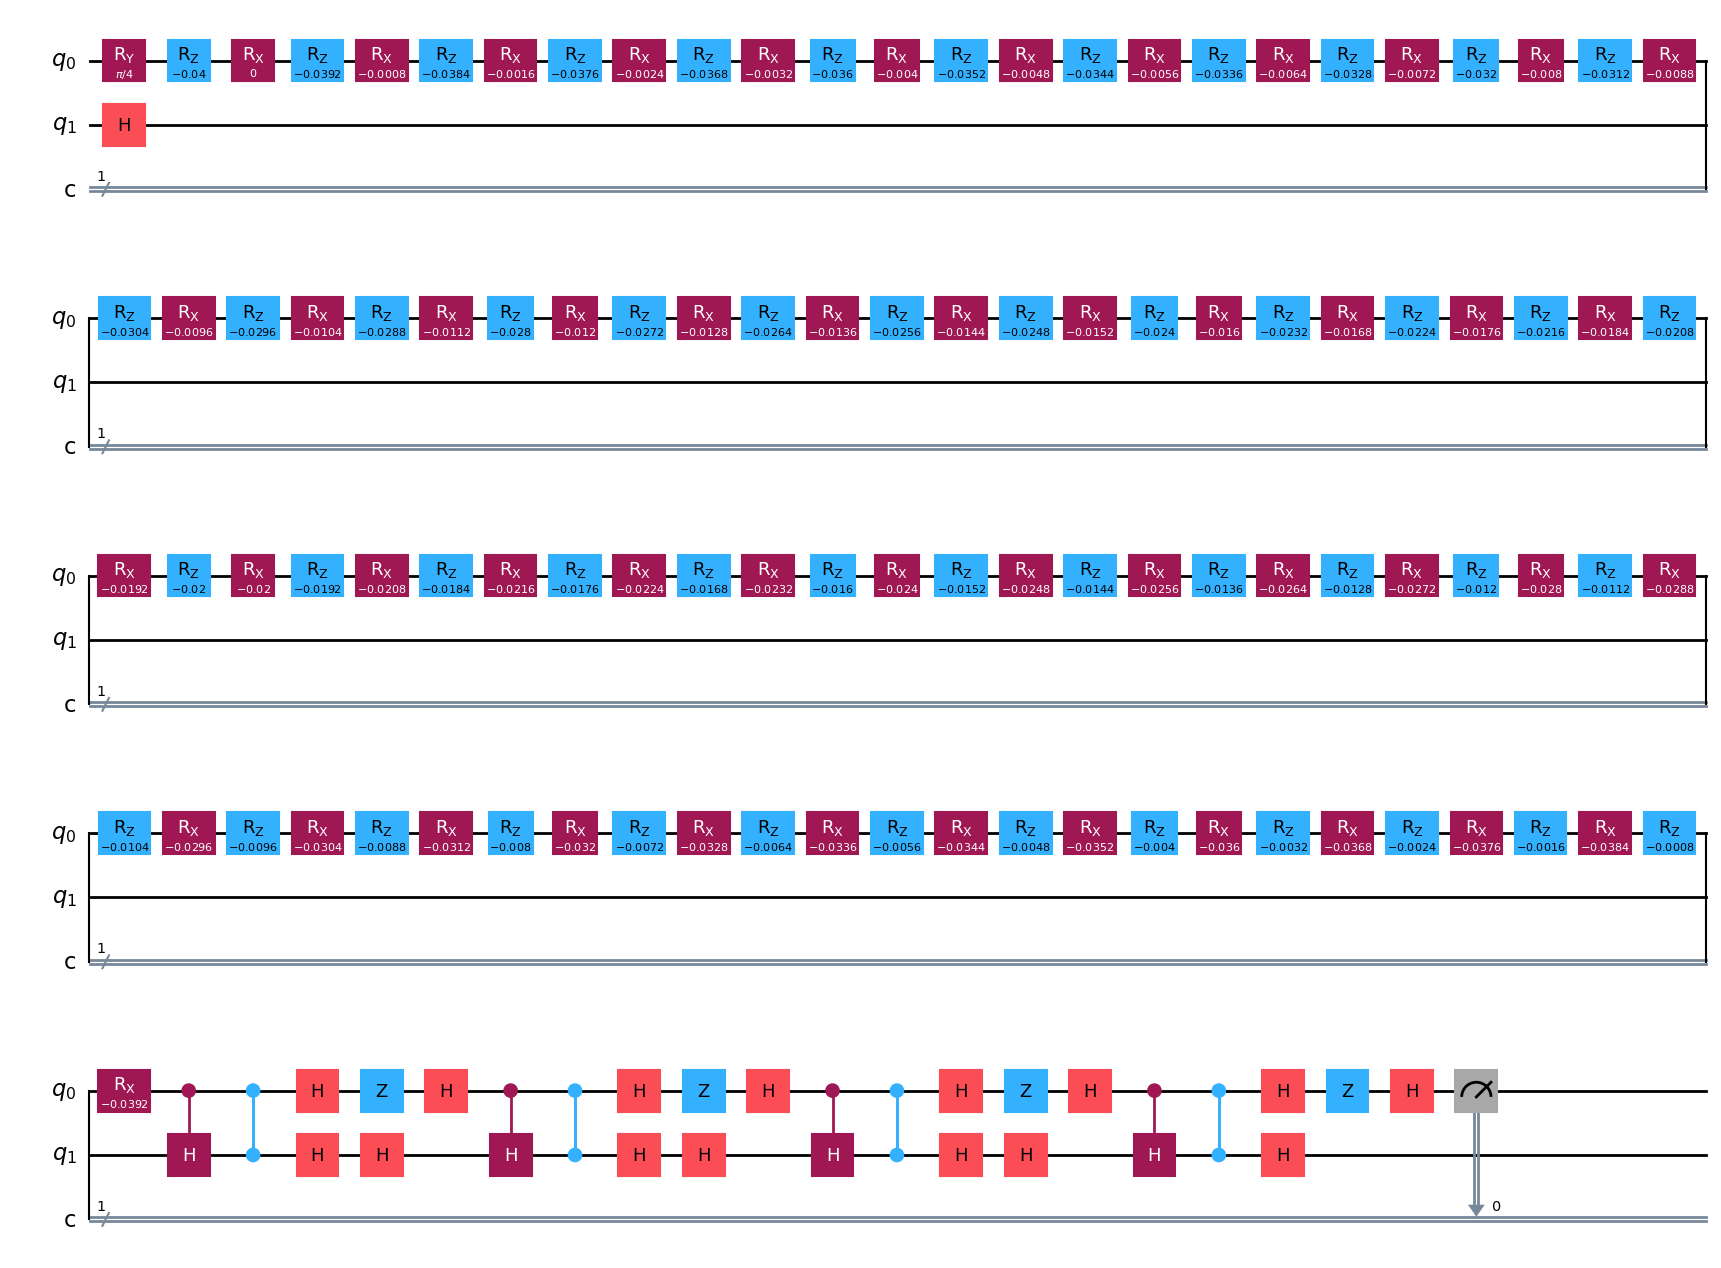

In [14]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
import numpy as np

# Oracle using interference-based detection with measurement
def interference_based_oracle(qc, candidate, ancillary):
    """Oracle that marks the state if it matches |ψ_f> using interference."""
    qc.h(ancillary)          # Put ancillary into superposition
    qc.ch(candidate, ancillary)  # Controlled-Hadamard on ancillary
    qc.cz(candidate, ancillary)  # Apply controlled phase flip
    qc.h(ancillary)          # Return ancillary to computational basis

# Main circuit with multiple Grover iterations and measurements
def recover_initial_state_with_measurements():    
    qc = QuantumCircuit(2, 1)  # 2 qubits, 1 classical bit for measurement
    candidate, ancillary = 0, 1

    # Step 1: Prepare the candidate initial state |ψ_0⟩
    qc.ry(np.pi / 4, candidate)  # Example state preparation

    # Step 2: Apply Hamiltonian evolution (simulating |ψ_0⟩ -> |ψ_f⟩)
    hamiltonian_evolution(qc, candidate, total_time=1.0, steps=50)

    # Step 3: Apply multiple Grover iterations
    num_iterations = 4
    for _ in range(num_iterations):
        interference_based_oracle(qc, candidate, ancillary)
        diffusion_operator(qc, candidate)

    # Step 4: Add measurement to verify recovery
    qc.measure(candidate, 0)

    # Simulate the final circuit with BasicSimulator
    simulator = BasicSimulator()
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    
    # Step 5: Plot the measurement results
    counts = result.get_counts()
    print(f"Measurement counts after {num_iterations} Grover iterations:", counts)
    plot_histogram(counts)
    return qc

# Trotterized Hamiltonian evolution function
def hamiltonian_evolution(qc, qubit, total_time, steps):
    dt = total_time / steps
    for _ in range(steps):
        s = _ / steps
        qc.rz(-2 * (1 - s) * dt, qubit)
        qc.rx(-2 * s * dt, qubit)

# Grover diffusion operator
def diffusion_operator(qc, qubit):
    qc.h(qubit)
    qc.z(qubit)
    qc.h(qubit)

# Run the recovery algorithm with measurements
qc = recover_initial_state_with_measurements()
qc.draw('mpl')


Measurement counts after 4 Grover iterations: {'0110': 378, '1100': 36, '0111': 105, '0011': 25, '1010': 22, '0100': 103, '0101': 24, '0010': 110, '1110': 117, '0000': 31, '1101': 9, '1111': 34, '1011': 8, '0001': 12, '1000': 7, '1001': 3}


<Figure size 1000x600 with 0 Axes>

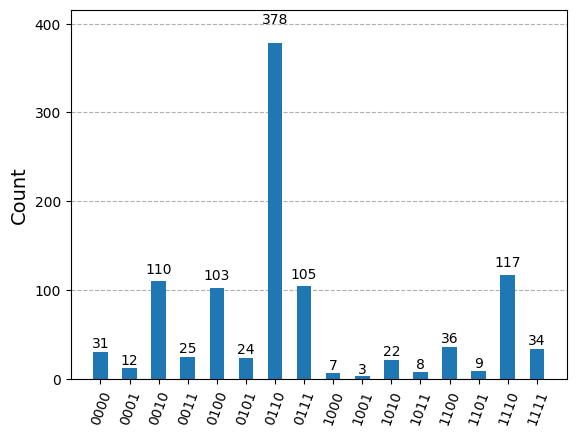

In [18]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Oracle for marking |0110⟩ using an interference-based technique
def interference_based_oracle(qc, qubits, ancillary):
    """Oracle that marks the state |0110⟩ using interference."""
    qc.x(qubits[0])
    qc.x(qubits[1])
    qc.h(ancillary)
    qc.mcx(qubits, ancillary)  # Multi-controlled NOT gate
    qc.h(ancillary)
    qc.x(qubits[0])
    qc.x(qubits[1])

# Main circuit with multiple Grover iterations and measurements
def recover_initial_state_with_measurements():    
    qc = QuantumCircuit(5, 4)  # 4 qubits + 1 ancillary, 4 classical bits for measurement
    qubits = [0, 1, 2, 3]
    ancillary = 4

    # Step 1: Prepare the initial state |0110⟩
    qc.x(1)  # Set qubit 1 to |1⟩
    qc.x(2)  # Set qubit 2 to |1⟩

    # Step 2: Apply Hamiltonian evolution to simulate |ψ_0⟩ -> |ψ_f⟩
    hamiltonian_evolution(qc, qubits, total_time=1.0, steps=50)

    # Step 3: Apply multiple Grover iterations
    num_iterations = 4
    for _ in range(num_iterations):
        interference_based_oracle(qc, qubits, ancillary)
        diffusion_operator(qc, qubits)

    # Step 4: Add measurements to verify recovery
    qc.measure(qubits, [0, 1, 2, 3])

    # Simulate the final circuit with BasicSimulator
    simulator = BasicSimulator()
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    
    # Step 5: Plot the measurement results
    counts = result.get_counts()
    print(f"Measurement counts after {num_iterations} Grover iterations:", counts)
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plot_histogram(counts)
    plt.show()
    
    return qc

# Trotterized Hamiltonian evolution function for multiple qubits
def hamiltonian_evolution(qc, qubits, total_time, steps):
    dt = total_time / steps
    for _ in range(steps):
        s = _ / steps
        for qubit in qubits:
            qc.rz(-2 * (1 - s) * dt, qubit)  # Z term
            qc.rx(-2 * s * dt, qubit)       # X term

# Grover diffusion operator for multiple qubits
def diffusion_operator(qc, qubits):
    """Apply the Grover diffusion operator to amplify the marked state."""
    for qubit in qubits:
        qc.h(qubit)
        qc.x(qubit)
    qc.h(qubits[-1])
    qc.mcx(qubits[:-1], qubits[-1])  # Multi-controlled Z
    qc.h(qubits[-1])
    for qubit in qubits:
        qc.x(qubit)
        qc.h(qubit)

# Run the recovery algorithm for 4 qubits and plot the results
qc = recover_initial_state_with_measurements()
#qc.draw('mpl')


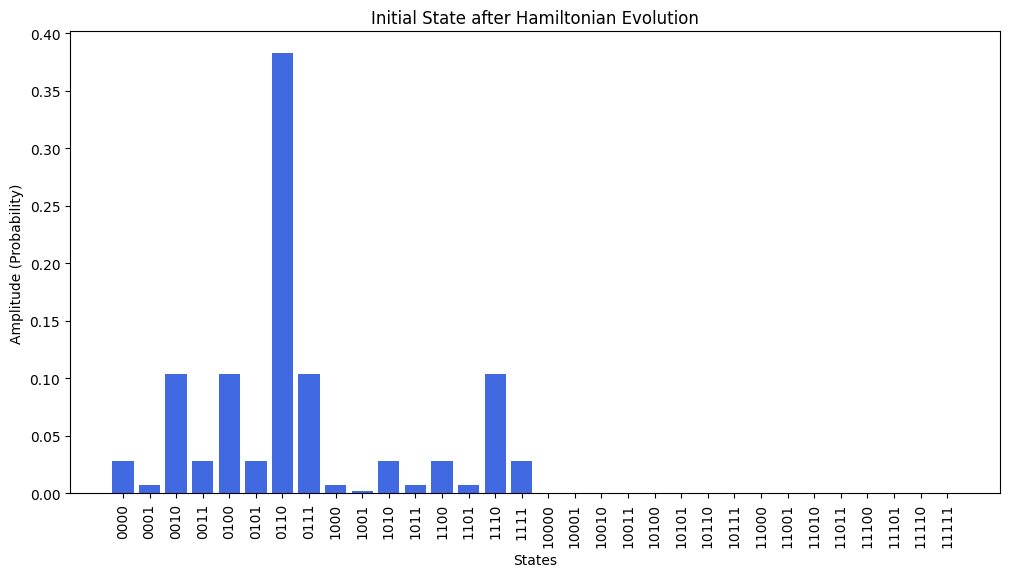

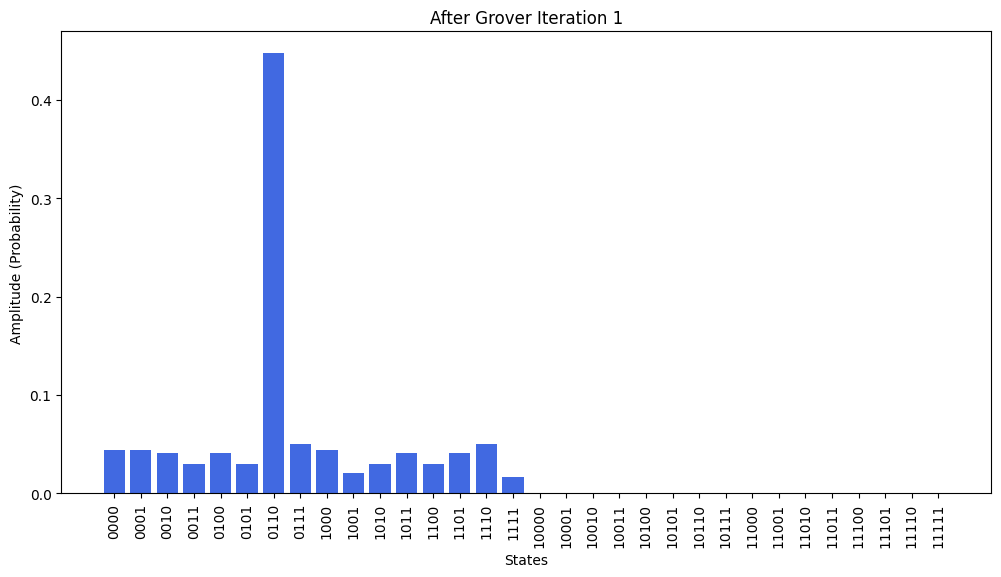

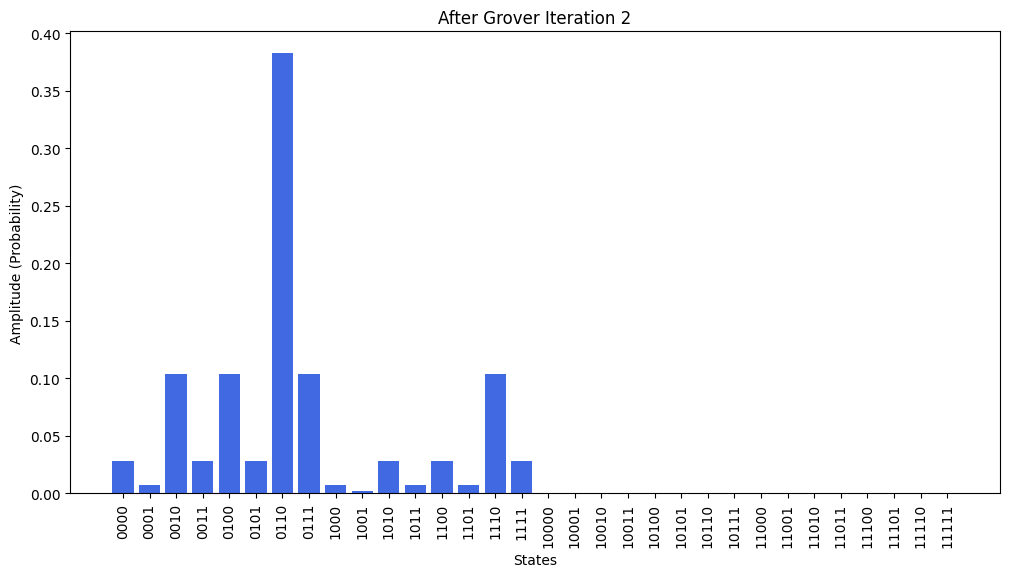

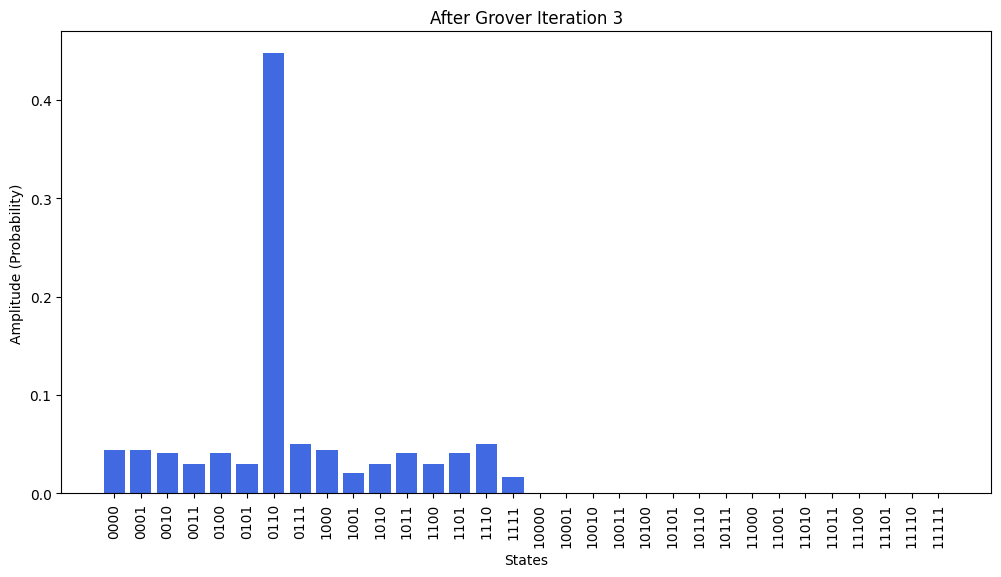

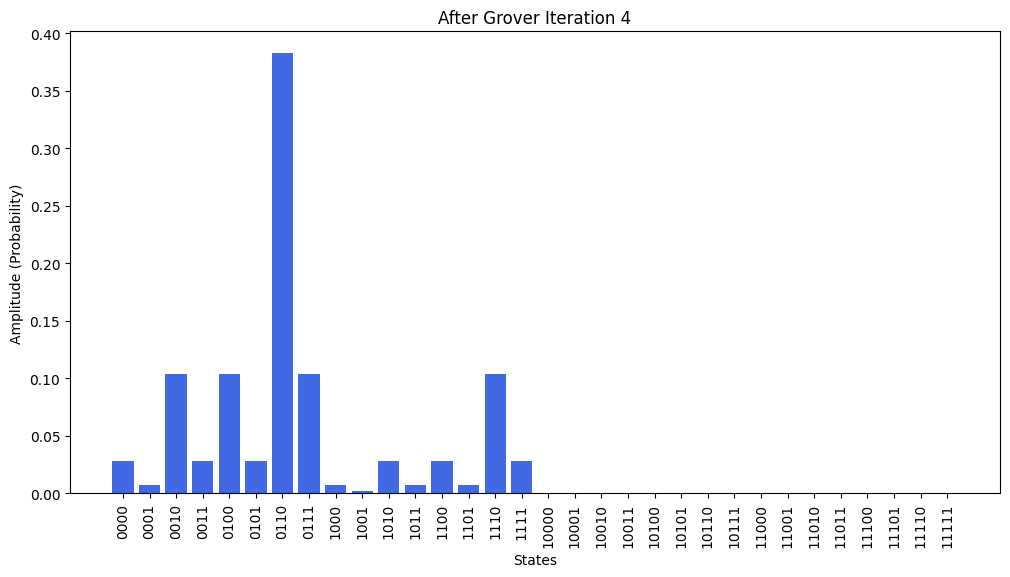

In [23]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import numpy as np

# Oracle for marking |0110⟩ using interference
def interference_based_oracle(qc, qubits, ancillary):
    """Oracle that marks the state |0110⟩ using interference."""
    qc.x(qubits[0])
    qc.x(qubits[1])
    qc.h(ancillary)
    qc.mcx(qubits, ancillary)  # Multi-controlled NOT gate
    qc.h(ancillary)
    qc.x(qubits[0])
    qc.x(qubits[1])

# Main circuit with multiple Grover iterations and amplitude visualization
def visualize_amplitudes():    
    qc = QuantumCircuit(5)  # 4 qubits + 1 ancillary
    qubits = [0, 1, 2, 3]
    ancillary = 4

    # Step 1: Prepare the initial state |0110⟩
    qc.x(1)  # Set qubit 1 to |1⟩
    qc.x(2)  # Set qubit 2 to |1⟩

    # Step 2: Apply Hamiltonian evolution to simulate |ψ_0⟩ -> |ψ_f⟩
    hamiltonian_evolution(qc, qubits, total_time=1.0, steps=50)

    # Plot initial amplitudes
    plot_amplitudes(qc, "Initial State after Hamiltonian Evolution")

    # Step 3: Apply multiple Grover iterations and visualize after each one
    num_iterations = 4
    for i in range(num_iterations):
        interference_based_oracle(qc, qubits, ancillary)
        diffusion_operator(qc, qubits)
        plot_amplitudes(qc, f"After Grover Iteration {i + 1}")

# Trotterized Hamiltonian evolution function for multiple qubits
def hamiltonian_evolution(qc, qubits, total_time, steps):
    dt = total_time / steps
    for _ in range(steps):
        s = _ / steps
        for qubit in qubits:
            qc.rz(-2 * (1 - s) * dt, qubit)  # Z term
            qc.rx(-2 * s * dt, qubit)       # X term

# Grover diffusion operator for multiple qubits
def diffusion_operator(qc, qubits):
    """Apply the Grover diffusion operator to amplify the marked state."""
    for qubit in qubits:
        qc.h(qubit)
        qc.x(qubit)
    qc.h(qubits[-1])
    qc.mcx(qubits[:-1], qubits[-1])  # Multi-controlled Z
    qc.h(qubits[-1])
    for qubit in qubits:
        qc.x(qubit)
        qc.h(qubit)

# Function to simulate and plot the amplitudes
def plot_amplitudes(qc, title):
    # simulator = BasicSimulator()
    # compiled_circuit = transpile(qc, simulator)
    # job = simulator.run(compiled_circuit, shots=1)
    # result = job.result()
    # statevector = Statevector(result.get_statevector())
    statevector = Statevector(qc)
    
    # Extract probabilities from the statevector
    amplitudes = np.abs(statevector.data)**2
    states = [f"{i:04b}" for i in range(len(amplitudes))]
    
    # Plot the amplitudes
    plt.figure(figsize=(12, 6))
    plt.bar(states, amplitudes, color='royalblue')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("States")
    plt.ylabel("Amplitude (Probability)")
    plt.show()

# Run the visualization
visualize_amplitudes()
